[Access code in github](https://github.com/oksanaprotsukha/time-series-CMIP/tree/main)

## Precipitation Patterns in Washington State: A Comparison of 1950-2000 and 2050-2100

In this notebook we are interested in identifying changes in precipitaion in Washinton State using CMIP6 data and mapping packages.

To understand how future precipitation patterns may differ from historical ones, we will compare the 1950-2000 historical baseline with the 2050-2100 future projection under ssp585 - very high emissions scenario.

1950-2000 Historical Baseline

* High quality data with good spatial coverage across Washington
* Captures multiple climate cycles 
* Corresponds to major water infrastructure development in Washington (e.g., major dams constructed during this period)

2050-2100 Future Projection

* Represents a mid to late future period with expected significant climate change signals
* Provides a peek into potential future precipitation patterns
* Allows for comparison with historical data to identify changes in precipitation patterns


## Region of Interest - Washington State

**Washington State** is located on the West Coast of the United States, bordering Canada to the north. The total area of the state is approximately 71,300 square miles. Its northerly latitude, between 46° and 49°, contributes to a generally mild climate.

The state’s topography is dominated by the Cascade Mountain Range, which divides Washington into western and eastern regions. West of the Cascades (Western Washington), the climate is maritime, with mild temperatures, high precipitation, and frequent fog. East of the Cascades (Eastern Washington), the climate exhibits both continental and marine influences, featuring hotter summers, colder winters, and lower precipitation.

The average annual temperature for the entire state is approximately 8.4°C.
Precipitation varies significantly by region. Western Washington typically receives 1,000–2,000 mm (39–79 inches) of precipitation annually, while Eastern Washington receives about 250–500 mm (10–20 inches) per year.
The state is characterized by diverse ecosystems, including temperate rainforests, alpine meadows, and arid shrublands. The climate and geography of Washington State play a critical role in shaping its natural resources, agriculture, and water management practices.
The state is also home to several major rivers, including the Columbia River. It is the largest river in the Pacific Northwest and serves as an essential water resource for the region. The Columbia River Basin is a key area for agriculture, hydropower generation, and fish habitat.

Climate change is expected to impact Washington State's precipitation patterns. It is likely that there will be increases in extreme weather events, shifts in seasonal precipitation, and changes in snowpack levels. These changes could have significant implications for water resources, agriculture, and ecosystems in the region.

Read about Washington state's climate on [the Regional Climate Centers (RCC) website](https://wrcc.dri.edu/Climate/narrative_wa.php).

![Washington State Map](Washington_topographic_map-fr.png)

*Image from [Wikimedia Commons](https://commons.wikimedia.org/wiki/File:Washington_topographic_map-fr.svg#filelinks)*

## CMIP6 Data

The CMIP6 data used in this analysis is sourced from the Earth System Grid Federation (ESGF) and includes multiple climate models and scenarios. In this analysis, I used canESM5 and CESM2 models for the SSP585 scenario.

### MPI-ESM1-2-H model
The MPI-ESM1-2-H (Max Planck Institute Earth System Model 1.2 - High Resolution) is a high-resolution version of the MPI-ESM1-2 climate model. It couples the atmosphere, ocean and land surface through the exchange of energy, momentum, water, and carbon dioxide and was specifically designed for studying Earth system processes and climate prediction. Higher resolution of this model provides a more detailed representation of the atmosphere, ocean, and land, leading to improved simulation of key climate features while reducing biases in the model's output. 

*Note*: Though the model is still being actively used in the CMIP project, it is no longer being developed. The development is currently focused on the new ICON model which offers similar features and configuration to the MPI-ESM1 model. 
More information about the model can be found in the article [Max Planck Institute Earth System Model (MPI-ESM1.2) for the High-Resolution Model Intercomparison Project (HighResMIP)](https://gmd.copernicus.org/articles/12/3241/2019/).

### CESM2 model
The Community Earth System Model version 2 (CESM2) is a state-of-the-art climate model developed by the National Center for Atmospheric Research (NCAR) in the United States. It is part of the Coupled Model Intercomparison Project Phase 6 (CMIP6) and is designed to simulate the Earth's climate system, including interactions between the atmosphere, oceans, land surface, and sea ice. CESM2 is widely used for climate research and projections, providing valuable insights into future climate scenarios and their potential impacts on various regions.

### SSP585 Scenario
The Shared Socioeconomic Pathways (SSP) are a set of scenarios that describe different pathways for future socioeconomic development and their implications for greenhouse gas emissions and climate change. The SSP585 scenario represents a fossil fueled development with high-emission pathway and projected radiative forcing of 8.5 W/m² by 2100. With an additional radiative forcing of 8.5 W/m² by the year 2100. Specifically, SSP585 assumes high economic and population growth coupled with the reliance on resource intensive lifestyles and reliance on fossil fuels to meet the increasing energy demand.

## Load and Query the CMIP6 AWS Catalog

In [1]:
# Import necessary libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
import s3fs
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
import scipy.stats as stats

### Define parameters

In [ ]:
# CMIP6 
model1 = 'MPI-ESM1-2-HR' # resolution 50 km
model2 = 'CESM2'
ssp_scenario = 'ssp585'
var = 'pr'

# region of interest 
# Washington State
lat_min, lat_max = 45.5, 49.1
lon_min, lon_max = 235.0, 243.5

# period of interest
# historical observations data
hist_start_date = '1950-01-01'
hist_end_date = '1999-12-31'

# future proejections data "2071-01-01", "2100-12-31"
ssp_start_date = '2050-01-01'
ssp_end_date = '2099-12-31'


In [3]:
## create a function to load and process CMIP6 data

def load_model_data(model, ssp_scenario, var):
    catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

    activity_ids = ['ScenarioMIP', 'CMIP']          # activity_id: CMIP = historical data, ScenarioMIP = future projections
    source_id = [model]                             # model name        
    experiment_ids = ['historical', ssp_scenario]   # emissions scenariios names
    table_id = 'Amon'                               # table_id: monthly atmosphere data  
    variable_id = var                               # variable of interest

    res = catalog.search(
        activity_id=activity_ids,
        source_id=source_id,
        experiment_id=experiment_ids,
        table_id=table_id,
        variable_id=variable_id
    )

    model_histdf = res.df[(res.df["source_id"] == model) & (res.df["experiment_id"] == "historical")]
    model_sspdf = res.df[(res.df["source_id"] == model) & (res.df["experiment_id"] == ssp_scenario)]

    hist_members = set(model_histdf['member_id'].unique())
    ssp_members = set(model_sspdf['member_id'].unique())
    common_members = sorted(hist_members.intersection(ssp_members))

    model_data = []

    for mem in common_members:
        hist_loc = model_histdf['member_id'][model_histdf['member_id'] == mem].index[0]
        ssp_loc = model_sspdf['member_id'][model_sspdf['member_id'] == mem].index[0]

        hist_data = xr.open_zarr(model_histdf['zstore'][hist_loc], storage_options={'anon': True})
        ssp_data = xr.open_zarr(model_sspdf['zstore'][ssp_loc], storage_options={'anon': True})

        temp_data = xr.concat([hist_data, ssp_data], dim="time")
        model_data.append(temp_data)

    model_data = xr.concat(model_data, dim="member")
    model_data = model_data.assign_coords(member=("member", common_members))

    return model_data


### Load Data From MPI-ESM1-2-HR Model
* Historical: Historical data (1950-2000)
* SSP585: Very high emissions (2051-2100)

In [4]:
# load CMIP6 data
model1_ds = load_model_data(model=model1, ssp_scenario=ssp_scenario, var=var)
# display(model1_ds)

### Load Data From CESM2 Model version 2 (NCAR - Community Earth System Model)
* Historical: Historical data (1950-2000)
* SSP585: Very high emissions (2050-2100)

In [5]:
model2_ds = load_model_data(model=model2, ssp_scenario=ssp_scenario, var=var)
# display(model2_ds)


## Subset the data to the the period and area of interest

In [6]:
def subset_by_time_and_region(data, start_date, end_date, lat_min, lat_max, lon_min, lon_max):
    """
    Subset the data to the the period and region of interest
    """
    # subset by time
    subset_data = data.sel(time=slice(start_date, end_date))

    # subset by region
    subset_data = subset_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

    return subset_data

# select the data for the given time period for model1
hist_model1_data = subset_by_time_and_region(model1_ds, hist_start_date, hist_end_date, lat_min, lat_max, lon_min, lon_max)
ssp_model1_data = subset_by_time_and_region(model1_ds, ssp_start_date, ssp_end_date, lat_min, lat_max, lon_min, lon_max)
# display(hist_model1_data, ssp_model1_data)

# select the data for the given time period for cesm2
hist_model2_data = subset_by_time_and_region(model2_ds, hist_start_date, hist_end_date, lat_min, lat_max, lon_min, lon_max)
ssp_model2_data = subset_by_time_and_region(model2_ds, ssp_start_date, ssp_end_date, lat_min, lat_max, lon_min, lon_max)
# display(hist_model2_data, ssp_model2_data)

## Calculate a Time Series for Precipitation in Washington State

### Calculate Average Precipitation per Period


In [7]:
hist_model1_mn = hist_model1_data.mean(dim="time").mean(dim="member")
ssp_model1_mn = ssp_model1_data.mean(dim="time").mean(dim="member")
# display(hist_model1_mn, ssp_model1_mn)

hist_model2_mn = hist_model2_data.mean(dim="time").mean(dim="member")
ssp_model2_mn = ssp_model2_data.mean(dim="time").mean(dim="member")
# display(hist_model2_mn, ssp_model2_mn)

## Calculate the Difference in Precipitation Between the Two Periods

In [8]:
model1_diff = ssp_model1_data.mean(dim="time") - hist_model1_data.mean(dim="time")
model1_diff_mn = model1_diff.mean(dim="member")

model2_diff = ssp_model2_data.mean(dim="time") - hist_model2_data.mean(dim="time")
model2_diff_mn = model2_diff.mean(dim="member")

# display(model1_diff_mn, model2_diff_mn)

In [9]:
# Extract precipitation values
# canESM5
hist_model1_mn_pr = hist_model1_mn.pr.values
ssp_model1_mn_pr = ssp_model1_mn.pr.values
model1_diff_mn_pr = model1_diff_mn.pr.values

# CESM2
hist_model2_mn_pr = hist_model2_mn.pr.values
ssp_model2_mn_pr = ssp_model2_mn.pr.values
model2_diff_mn_pr = model2_diff_mn.pr.values

In [45]:
print(hist_model2_data.pr.units, ssp_model2_data.pr.units)
print(hist_model1_data.pr.units, ssp_model1_data.pr.units)

kg m-2 s-1 kg m-2 s-1
kg m-2 s-1 kg m-2 s-1


In [47]:
# get max and min values excluding NaN values

hist_model1_mn_pr = np.nan_to_num(hist_model1_mn_pr, nan=0.0)
ssp_model1_mn_pr = np.nan_to_num(ssp_model1_mn_pr, nan=0.0)
model1_diff_mn_pr = np.nan_to_num(model1_diff_mn_pr, nan=0.0)

# print(hist_model1_mn_pr.min(), hist_model1_mn_pr.max())
# print(ssp_model1_mn_pr.min(), ssp_model1_mn_pr.max())
# print(model1_diff_mn_pr.min(), model1_diff_mn_pr.max())

# print(hist_model2_mn_pr.min(), hist_model2_mn_pr.max())
# print(ssp_model2_mn_pr.min(), ssp_model2_mn_pr.max())
# print(model2_diff_mn_pr.min(), model2_diff_mn_pr.max())

In [ ]:
#convert units to mm/day
hist_model1_pr = hist_model1_mn_pr * 86400  
ssp_model1_pr = ssp_model1_mn_pr * 86400
model1_diff_pr = model1_diff_mn_pr * 86400  

hist_model2_pr = hist_model2_mn_pr * 86400
ssp_model2_pr = ssp_model2_mn_pr * 86400
model2_diff_pr = model2_diff_mn_pr * 86400 

Text(0.5, 1.0, 'CESM2 precip (SSP585)')

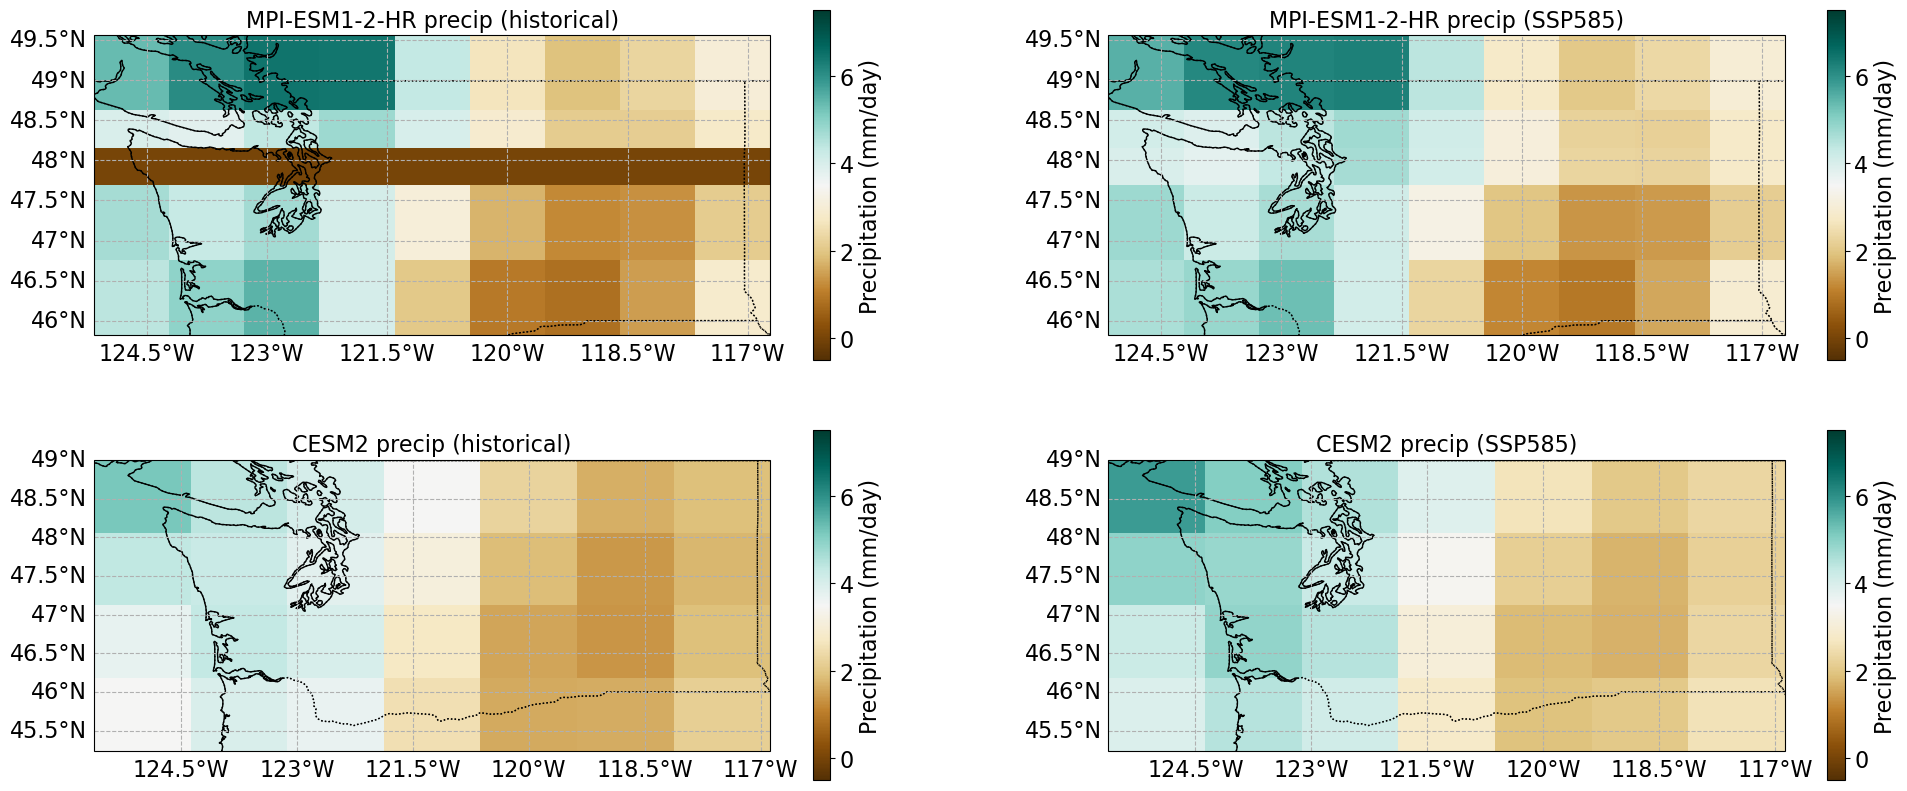

In [26]:
map = ccrs.PlateCarree()

# Make a figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 10), subplot_kw={"projection": map})

# Subplot 1: MPI-ESM1-2-HR - Historical
plot1 = axes[0, 0].pcolormesh(hist_model1_mn.lon, hist_model1_mn.lat, 
                            hist_model1_pr, transform=map, cmap="BrBG",
                            vmin=-0.5, vmax=7.5)

# Add coastlines, state borders, and gridlines
axes[0, 0].add_feature(cfeature.COASTLINE)
axes[0, 0].add_feature(cfeature.STATES, linestyle=":")

gl1 = axes[0, 0].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {"size": 16}
gl1.ylabel_style = {"size": 16}

# Add colorbar
cbar1 =plt.colorbar(plot1, ax=axes[0, 0],
                    orientation="vertical")
cbar1.set_label("Precipitation (mm/day)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[0, 0].set_title("MPI-ESM1-2-HR precip (historical)", fontsize=16)


# Subplot 2: MPI-ESM1-2-HR - SSP585
plot2 = axes[0, 1]. pcolormesh(ssp_model1_mn.lon, ssp_model1_mn.lat, 
                            ssp_model1_pr, transform=map, cmap="BrBG",
                            vmin=-0.5, vmax=7.5)

# Add coastlines, state borders, and gridlines
axes[0, 1].add_feature(cfeature.COASTLINE)
axes[0, 1].add_feature(cfeature.STATES, linestyle=":")

gl1 = axes[0, 1].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {"size": 16}
gl1.ylabel_style = {"size": 16}

# Add colorbar
cbar1 =plt.colorbar(plot2, ax=axes[0, 1],
                    orientation="vertical")
cbar1.set_label("Precipitation (mm/day)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[0, 1].set_title("MPI-ESM1-2-HR precip (SSP585)", fontsize=16)

# Subplot 3: CESM2 - Historical
plot3 = axes[1, 0]. pcolormesh(hist_model2_mn.lon, hist_model2_mn.lat, 
                            hist_model2_pr, transform=map, cmap="BrBG",
                            vmin=-0.5, vmax=7.5)

# Add coastlines, state borders, and gridlines
axes[1, 0].add_feature(cfeature.COASTLINE)
axes[1, 0].add_feature(cfeature.STATES, linestyle=":")

gl1 = axes[1, 0].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {"size": 16}
gl1.ylabel_style = {"size": 16}

# Add colorbar
cbar1 =plt.colorbar(plot3, ax=axes[1, 0],
                    orientation="vertical")
cbar1.set_label("Precipitation (mm/day)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[1, 0].set_title("CESM2 precip (historical)", fontsize=16)

# Subplot 4: CESM2 - SSP585
plot4 = axes[1, 1]. pcolormesh(ssp_model2_mn.lon, ssp_model2_mn.lat, 
                            ssp_model2_pr, transform=map, cmap="BrBG",
                            vmin=-0.5, vmax=7.5)

# Add coastlines, state borders, and gridlines
axes[1, 1].add_feature(cfeature.COASTLINE)
axes[1, 1].add_feature(cfeature.STATES, linestyle=":")

gl1 = axes[1, 1].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {"size": 16}
gl1.ylabel_style = {"size": 16}

# Add colorbar
cbar1 =plt.colorbar(plot4, ax=axes[1, 1],
                    orientation="vertical")
cbar1.set_label("Precipitation (mm/day)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[1, 1].set_title("CESM2 precip (SSP585)", fontsize=16)


#### Plot Difference in Precipitation Between Historical Observations and Future Projections on the Map

Text(0.5, 1.0, 'CESM2 precip (mid-century - historical)')

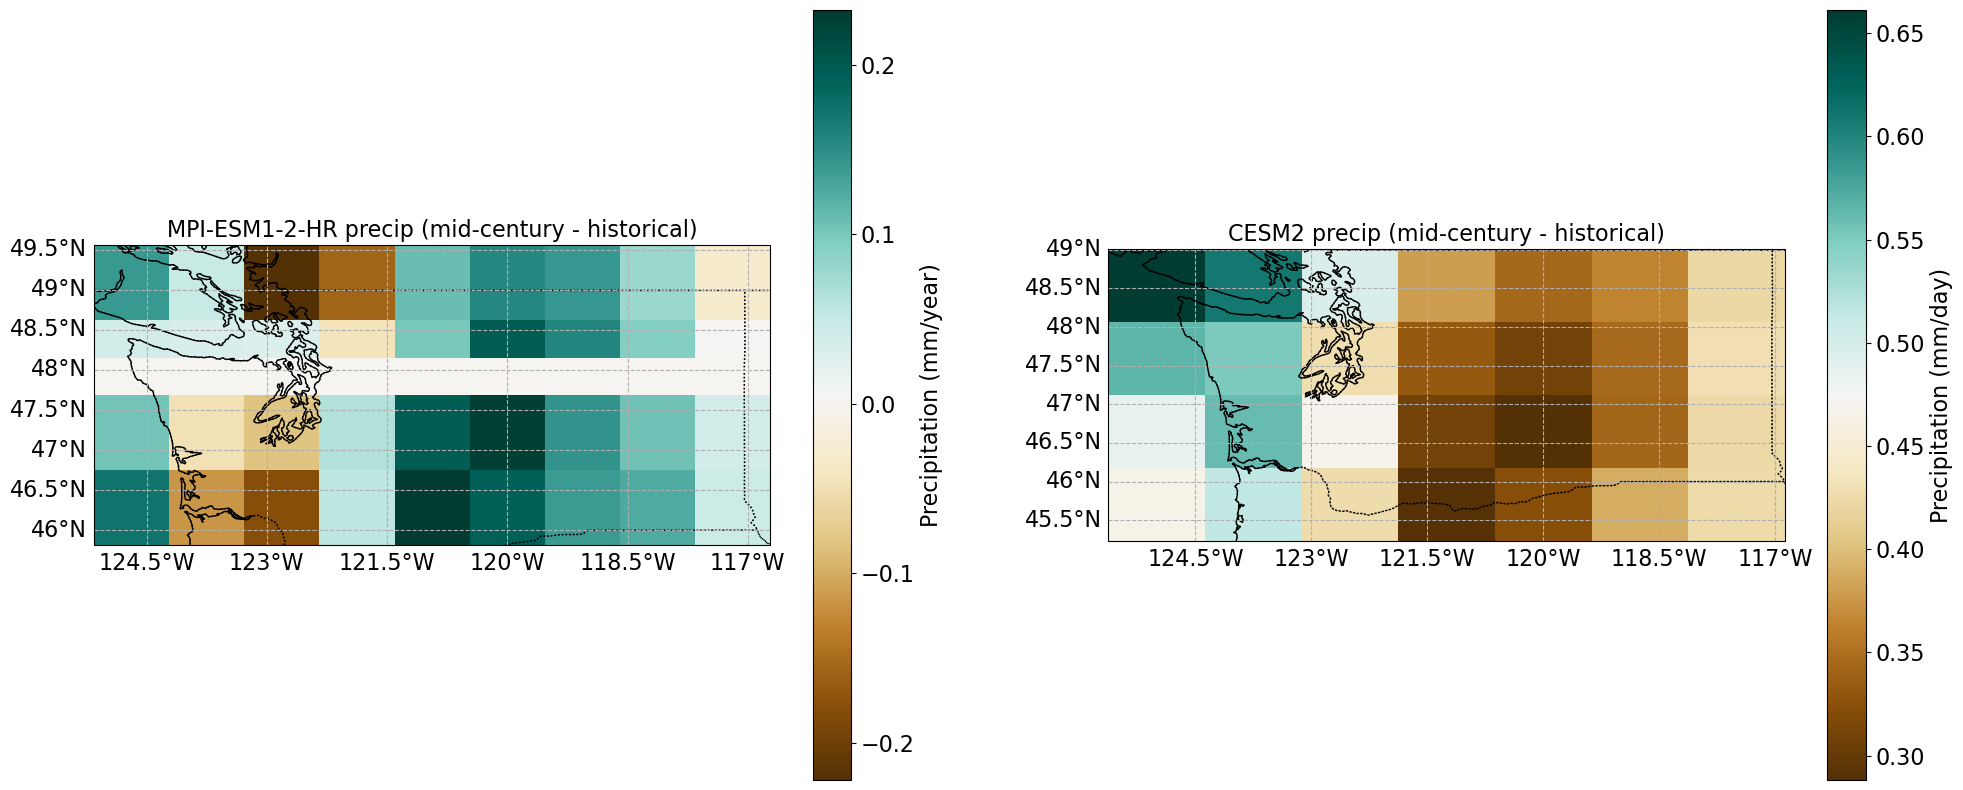

In [44]:
map = ccrs.PlateCarree()

# Make a figure with two subplots
fig, axes = plt.subplots(ncols=2, figsize=(24, 10), subplot_kw={"projection": map})

# Subplot 1: MPI-ESM1-2-HR - Difference
plot1 = axes[0]. pcolormesh(model1_diff_mn.lon, model1_diff_mn.lat, 
                            model1_diff_pr, transform=map, cmap="BrBG",
                             vmin=model1_diff_pr.min(), vmax=model1_diff_pr.max()) 

# Add coastlines, state borders, and gridlines
axes[0].add_feature(cfeature.COASTLINE)
axes[0].add_feature(cfeature.STATES, linestyle=":")

gl1 = axes[0].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {"size": 16}
gl1.ylabel_style = {"size": 16}

# Add colorbar
cbar1 =plt.colorbar(plot1, ax=axes[0],
                    orientation="vertical")
cbar1.set_label("Precipitation (mm/year)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[0].set_title("MPI-ESM1-2-HR precip (mid-century - historical)", fontsize=16)


# Subplot 2: CESM2 - Difference
plot2 = axes[1]. pcolormesh(model2_diff_mn.lon, model2_diff_mn.lat, 
                            model2_diff_pr, transform=map, cmap="BrBG",
                            vmin=model2_diff_pr.min(), vmax=model2_diff_pr.max())

# Add coastlines, state borders, and gridlines
axes[1].add_feature(cfeature.COASTLINE)
axes[1].add_feature(cfeature.STATES, linestyle=":")

gl1 = axes[1].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {"size": 16}
gl1.ylabel_style = {"size": 16}

# Add colorbar
cbar1 =plt.colorbar(plot2, ax=axes[1],
                    orientation="vertical")
cbar1.set_label("Precipitation (mm/day)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[1].set_title("CESM2 precip (mid-century - historical)", fontsize=16)


## Interpretation

From the maps, we can see that the two models capture slightly different patterns of precipitation in Washington State. Surprisingly, both models show a slight increase in precipitation in the future. The differences between the two periods are minimal. However, the current analysis looked at the mean precipitation over the entire time period, which does not capture seasonal variations in precipitation patterns. It is likely that we might notice increased precipitation in the winter months and decreased precipitation in the summer months; however, these effects will be canceled out in this analysis since we do not account for the seasonal variations. Further analysis is needed to uncover the seasonal variations in precipitation patterns and how they vary across the state. 
Additionally, it might be beneficial to use models that offer downscaled projections for Washington State or regional climate models that are specifically designed to capture local climate features and variations.